In [1]:
import os
import sys
root = os.path.abspath("")
sys.path.insert(0, f"{root}/build/python")

import matplotlib.pyplot as plt

import drjit as dr
import mitsuba as mi

mi.set_variant('llvm_ad_rgb')

from mitsuba import ScalarTransform4f as T
from mitsuba import ScalarTransform4f as T

from test_vec import Rayloader
import dummy_sensor

sensor_count = 5
sensors = []

for i in range(sensor_count):
    angle = 180.0 / sensor_count * i - 90.0
    sensor_rotation = T.rotate([0, 1, 0], angle)
    sensor_to_world = T.look_at(target=[0, 0, 0], origin=[0, 0, 4], up=[0, 1, 0])
    sensors.append(mi.load_dict({
        'type': 'perspective',
        'fov': 45,
        'to_world': sensor_rotation @ sensor_to_world,
        'film': {
            'type': 'hdrfilm',
            'width': 64, 'height': 64,
            'filter': {'type': 'tent'}
        }
    }))

/home/simeng/mitsuba3


In [2]:
scene_dict = {
    'type': 'scene',
    'integrator': {'type': 'prbvolpath'},
    'object': {
        'type': 'cube',
        'bsdf': {'type': 'null'},
        'interior': {
            'type': 'heterogeneous',
            'sigma_t': {
                'type': 'gridvolume',
                'filename': './tutorials/scenes/volume.vol',
                'to_world': T.rotate([1, 0, 0], -90).scale(2).translate(-0.5)
            },
            'scale': 40
        }
    },
    'emitter': {'type': 'constant'}
}

scene_ref = mi.load_dict(scene_dict)

# Number of samples per pixel for reference images
ref_spp = 512

3


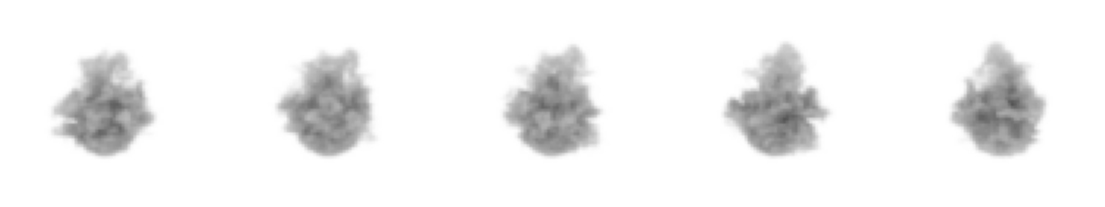

In [3]:
ref_images = [mi.render(scene_ref, sensor=sensors[i], spp=ref_spp) for i in range(sensor_count)]
#ref_images = mi.render(scene_ref, sensor=sensors, spp=ref_spp)
fig, axs = plt.subplots(1, sensor_count, figsize=(14, 4))
for i in range(sensor_count):
    axs[i].imshow(mi.util.convert_to_bitmap(ref_images[i]))
    axs[i].axis('off')
print(ref_images[0].shape[2])

In [4]:
a = mi.TensorXf([1, 1, 5, 2, 2, 6, 3, 3, 7, 4], shape=(2, 5))
b = mi.TensorXf([12, 11, 10, 12, 12, 16, 13, 13, 17, 14], shape=(2, 5))
c = [a, b]
d = [dr.ravel(c[i]) for i in range(2)]
print(dr.ravel(c))
# print(d)
# print(d[0])
# channels = len(c)
# length = dr.width(a[0])
index = dr.arange(mi.Int, 0, 4, 1)
print(index[0:2])
data = dr.zeros(mi.Float, 10)
data[0: 3] = index[0:3]
print(data)
# print(index)
#tempo = dr.gather(mi.Float, data, d[0], index)
# for i in range(channels):
#     dr.scatter(data, d[i], index + i)
#print(data)

[TensorXf(shape=(2, 5)), TensorXf(shape=(2, 5))]
[0, 1]
[0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


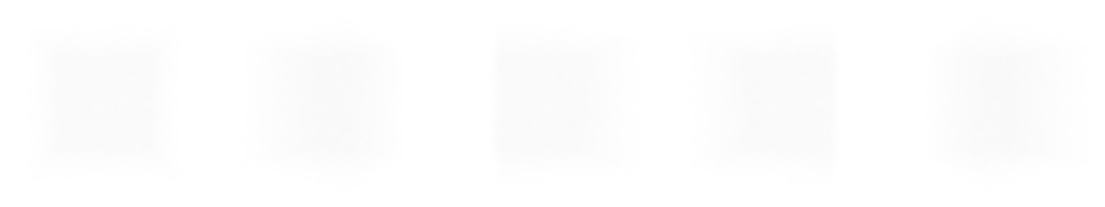

In [5]:
v_res = 16

# Modify the scene dictionary
scene_dict['object'] = {
    'type': 'cube',
    'interior': {
        'type': 'heterogeneous',
        'sigma_t': {
            'type': 'gridvolume',
            'grid': mi.VolumeGrid(dr.full(mi.TensorXf, 0.002, (v_res, v_res, v_res, 1))),
            'to_world': T.translate(-1).scale(2.0)
        },
        'scale': 40.0,
    },
    'bsdf': {'type': 'null'}
}

scene = mi.load_dict(scene_dict)

init_images = [mi.render(scene, sensor=sensors[i], spp=ref_spp) for i in range(sensor_count)]

fig, axs = plt.subplots(1, sensor_count, figsize=(14, 4))
for i in range(sensor_count):
    axs[i].imshow(mi.util.convert_to_bitmap(init_images[i]))
    axs[i].axis('off')

params = mi.traverse(scene)

key = 'object.interior_medium.sigma_t.data'

opt = mi.ad.Adam(lr=0.02)
opt[key] = params[key]
params.update(opt);

iteration_count = 40
spp = 8

cus_sensor = mi.load_dict({'type': 'custom_sensor',
                           'id': 'cus',
                           }) #FIXME

# scene is the start scene
ray_loader = Rayloader(scene, params, cus_sensor, sensors, ref_images, spp = spp)

for it in range(iteration_count):
    total_loss = 0
    for sensor_idx in range(sensor_count):
        # Perform the differentiable light transport simulation
        img = mi.render(scene, params, sensor=sensors[sensor_idx], spp=spp, seed=it)

        # L2 loss function
        loss = dr.mean(dr.sqr(img - ref_images[sensor_idx]))

        # Backpropagate gradients
        dr.backward(loss)

        # Take a gradient step
        opt.step()

        # Clamp the optimized density values. Since we used the `scale` parameter
        # when instantiating the volume, we are in fact optimizing extinction
        # in a range from [1e-6 * scale, scale].
        opt[key] = dr.clamp(opt[key], 1e-6, 1.0)

        # Propagate changes to the scene
        params.update(opt)

        total_loss += loss[0]
    print(f"Iteration {it:02d}: error={total_loss:6f}", end='\r')

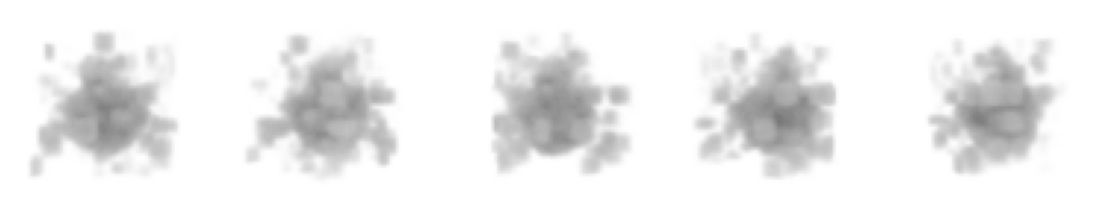

In [6]:
intermediate_images = [mi.render(scene, sensor=sensors[i], spp=ref_spp) for i in range(sensor_count)]

fig, axs = plt.subplots(1, sensor_count, figsize=(14, 4))
for i in range(sensor_count):
    axs[i].imshow(mi.util.convert_to_bitmap(intermediate_images[i]))
    axs[i].axis('off')